# 로지스틱 회귀로 와인 분류하기

In [ ]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


alcohol,sugar, pH, class 4개의 열로 구성

In [ ]:
wine.info() #누락된 값 찾기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


누락된 값이 있다면?
 1. 데이터 버리기
 2. 훈련 셋의 평균값으로 채우기

In [ ]:
wine.describe() #각 열에 대한 통계값 제공

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)

In [ ]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


**표준화**

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

**훈련**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


과소적합 개선방안

-> 규제 매개변수 C 조절, solver 매개변수에서 다른 알고리즘 선택, 다항특성

# 로지스틱 회귀의 한계

왜 이런 계수값이 나왔을까?

알코올 도수, 당도가 높을수록 화이트 와인(양성)일 가능성이 높고 pH가 높을수록 레드와인일 가능성이 높다고 예측할 뿐 값에 대한 정확한 설명 불가 -> 순서도로 변환

In [ ]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


# 결정 트리
**사이킷런의 DecisionTreeClassifier**

매개변수

- criterion : 불순도 지정
> gini / entropy
- splitter : 노드 분할 전략
> best(정보 이득 최대 방향)/ random(임의)
- max_depth : 트리 성장할 최대 깊이
> None(순수하거나 지정한 최소 샘플 수보다 작아질 때 까지)
- min_samples_split : 노드를 나누기 위한 최소 샘플 수
- max_features : 최적의 분할을 위해 탐색할 특성의 개수


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42) #최적의 분할을 찾기 전에 특성의 순서를 섞는다
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_input, test_target))

0.996921300750433
0.7376923076923076


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

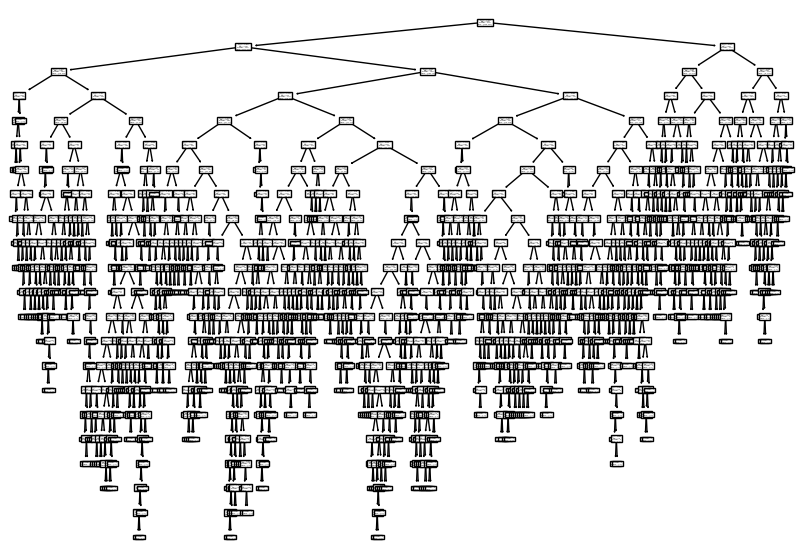

In [ ]:
plt.figure(figsize=(10, 7))
plot_tree(dt) #plot_tree 함수 : 결정 트리를 이해하기 쉬운 트리 그림으로 출력
plt.show()

**노드**

훈련 데이터의 특성에 대한 테스트를 표현

 ex) 샘플의 당도가 -0.239보다 작거나 같은지

맨 위 노드 : root node

맨 아래 노드 : leaf node

**가지**

: 테스트 결과 표현 (T/F)

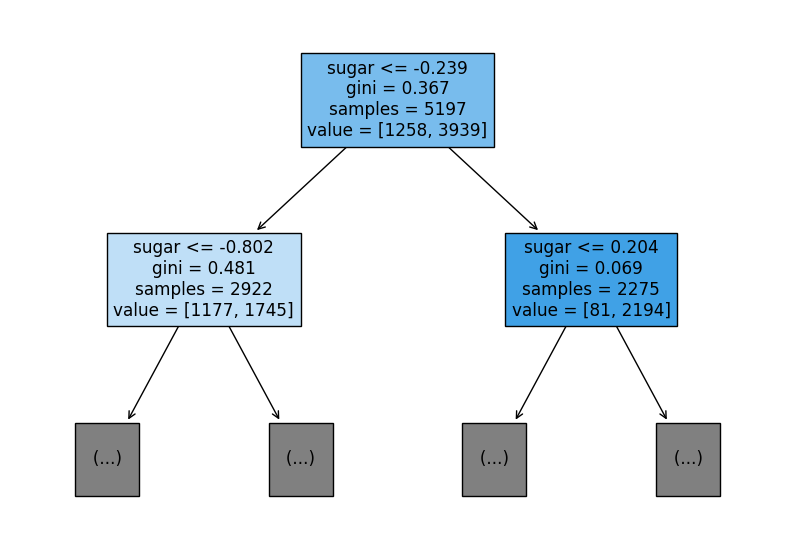

In [ ]:
plt.figure(figsize=(10, 7))
plot_tree(dt, max_depth = 1, filled = True, feature_names = ['alchol', 'sugar', 'pH'])
plt.show()

1. 테스트 조건
2. 불순도(gini)
3. 총 샘플 수
4. 클래스별 샘플 수 [음성, 양성]

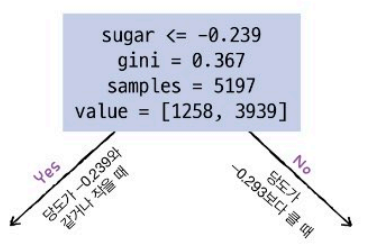

* 어떤 클래스의 비율이 높아질수록
진한색으로 표시
* 예측 클래스는 리프 노드에서 가장 많은 클래스

**불순도** - 테스트 조건을 결정

1. 지니 불순도(gini)
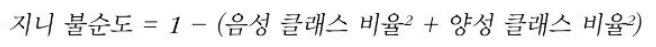
- 클래스가 고르게 섞여있을수록 불순도 높아짐
2. 엔트로피 불순도
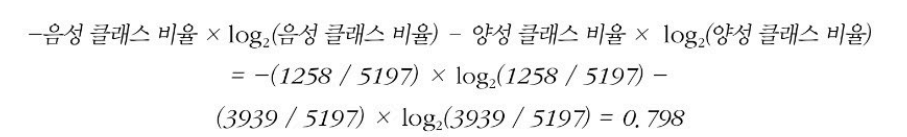

**정보 이득**

부모 노드와 자식 노드의 불순도 차이

- 결정 트리 모델은 부모 노드와 자식 노드의 불순도 차이(정보 이득)가 크도록 트리를 성장시킴
- 트리는 점점 노드를 순수하게 나눔

**가지치기**
- 트리가 순수해질 때 까지 무한히 자란다면 과대적합이 발생하여 트리의 최대 깊이를 지정하는 방법

- max_depth 매개변수 지정

In [ ]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42) #깊이 3까지만 성장
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

0.8454877814123533
0.8415384615384616


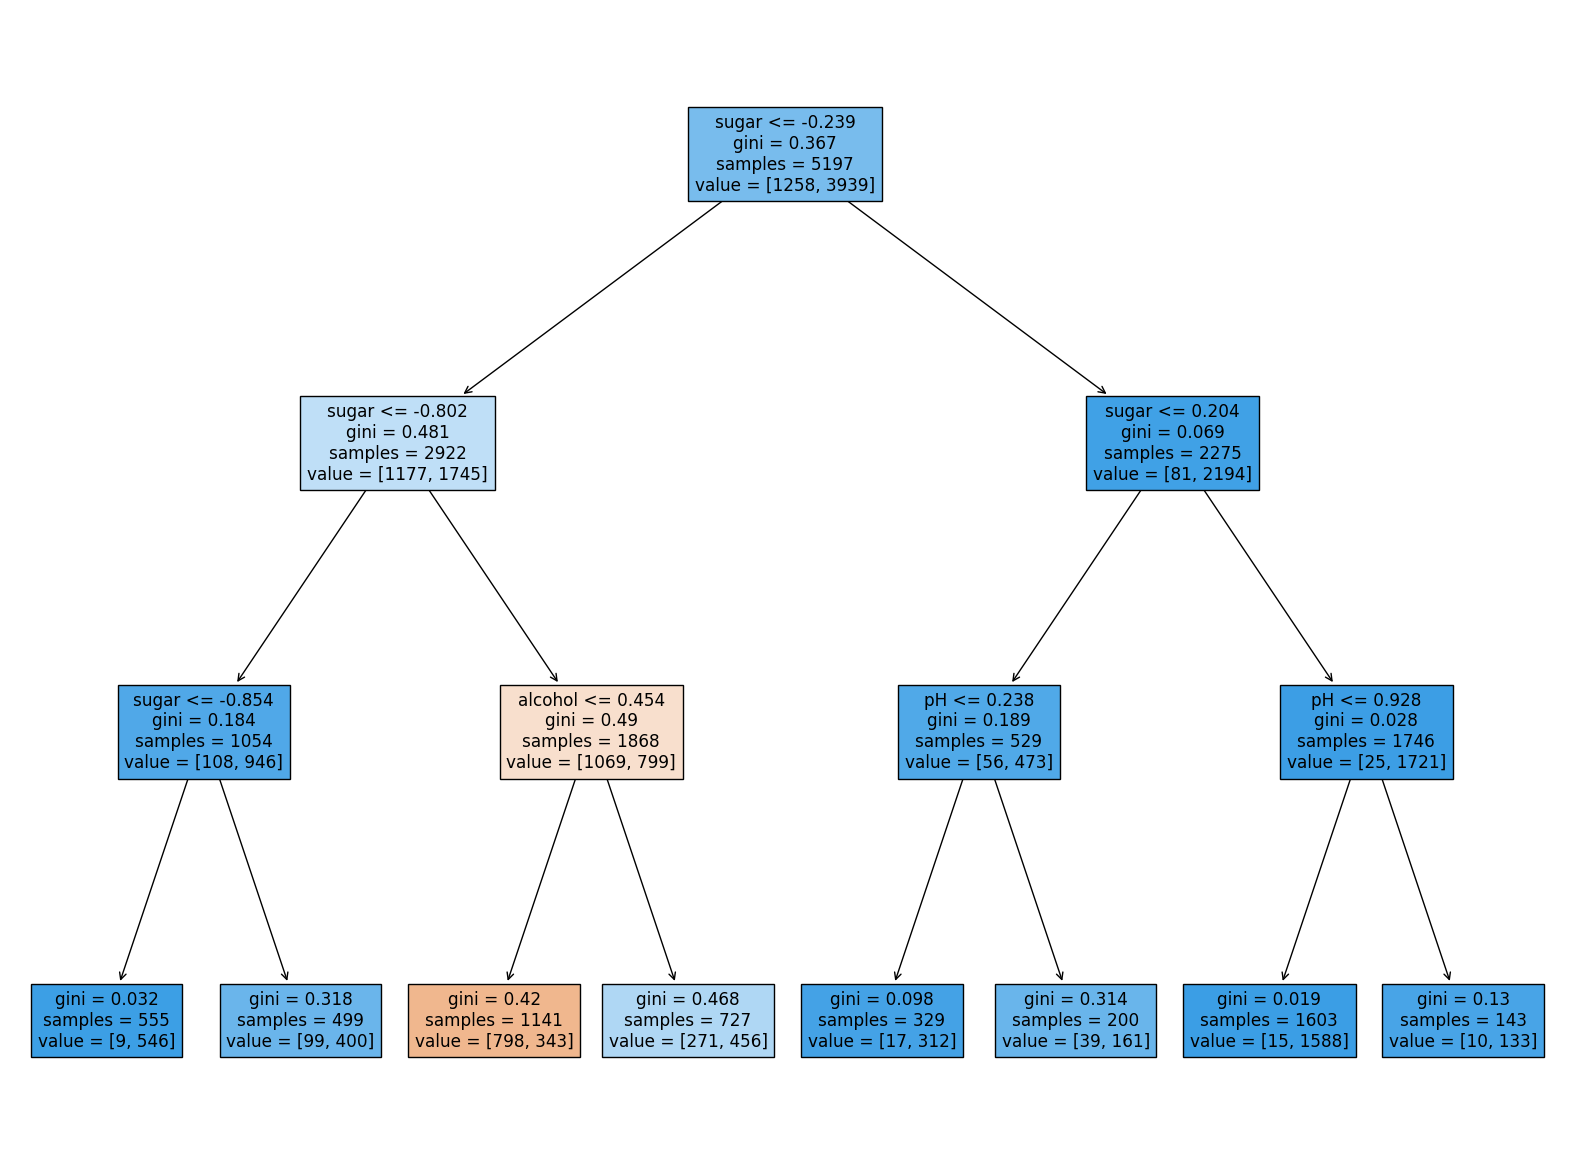

In [ ]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

결정트리는 표준화 전처리 과정이 불필요

In [ ]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42) #깊이 3까지만 성장
dt.fit(train_input, train_target)
print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


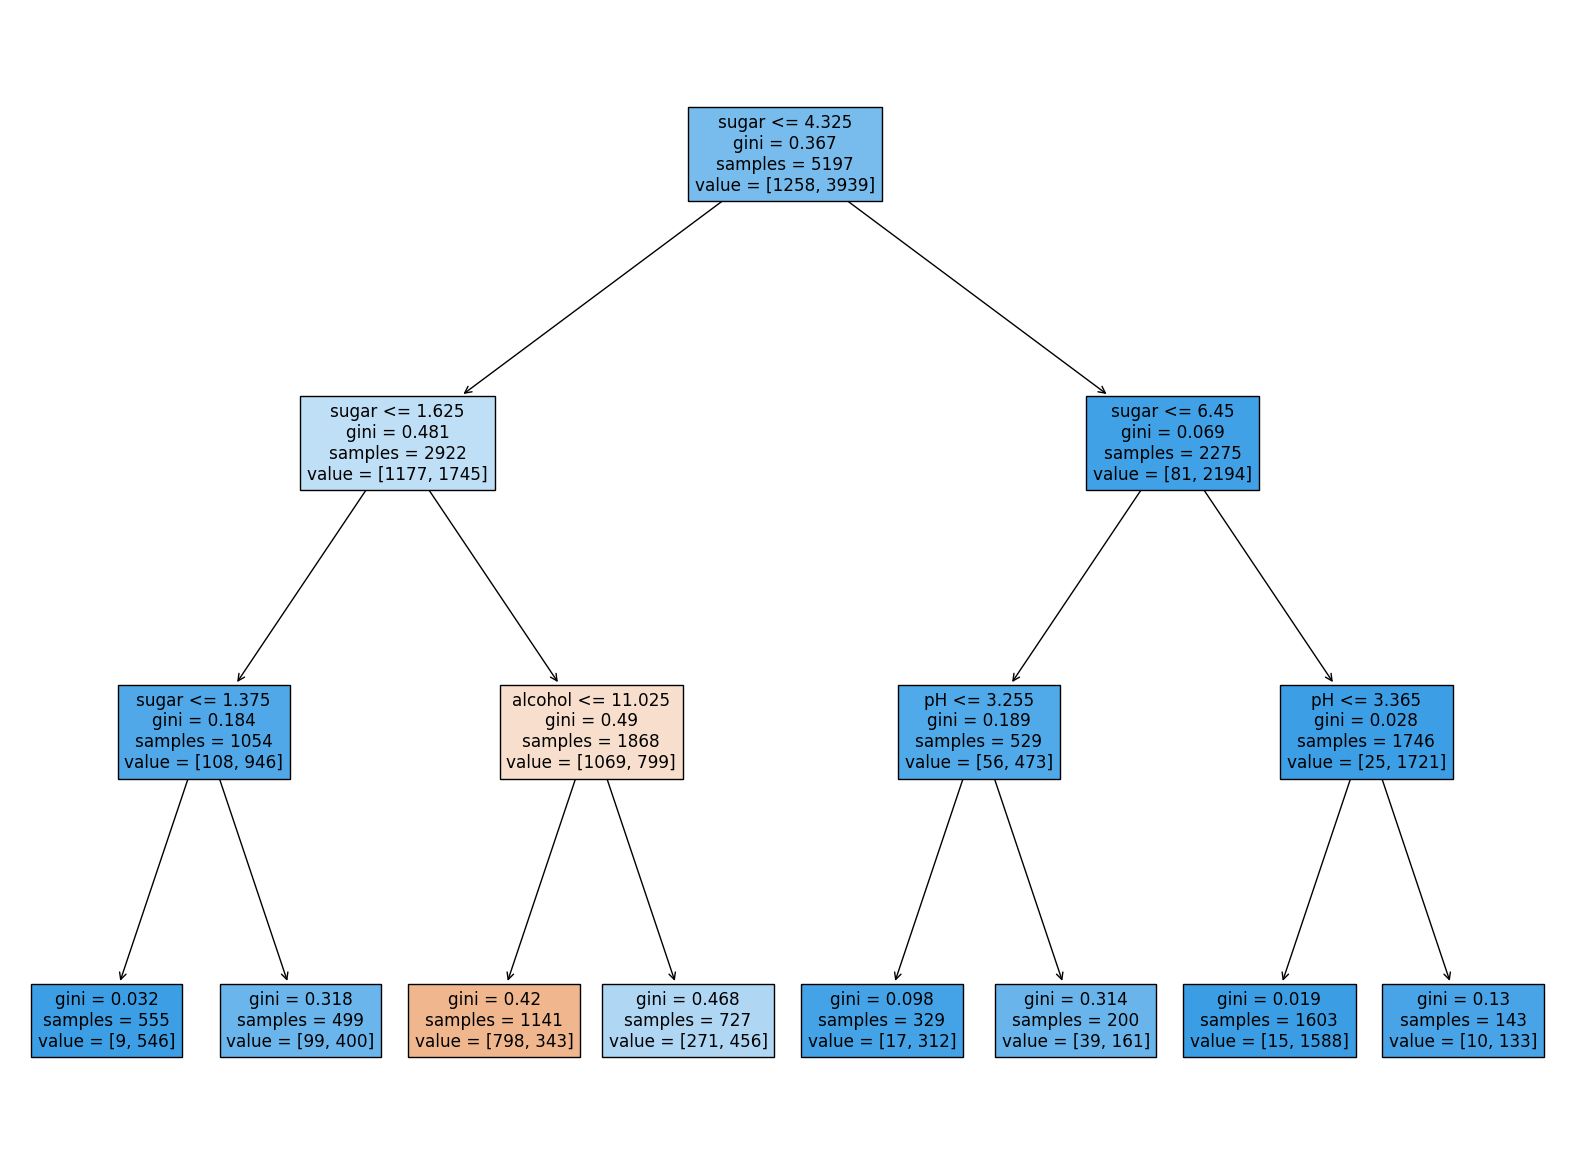

In [ ]:
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

**특성 중요도**

결정 트리에 사용된 특성이 불순도를 감소하는데 기여한 정도

In [ ]:
print(dt.feature_importances_) # sugar 의 중요도가 가장 높음

[0.12345626 0.86862934 0.0079144 ]


**예제**

0.8874350586877044
0.8615384615384616


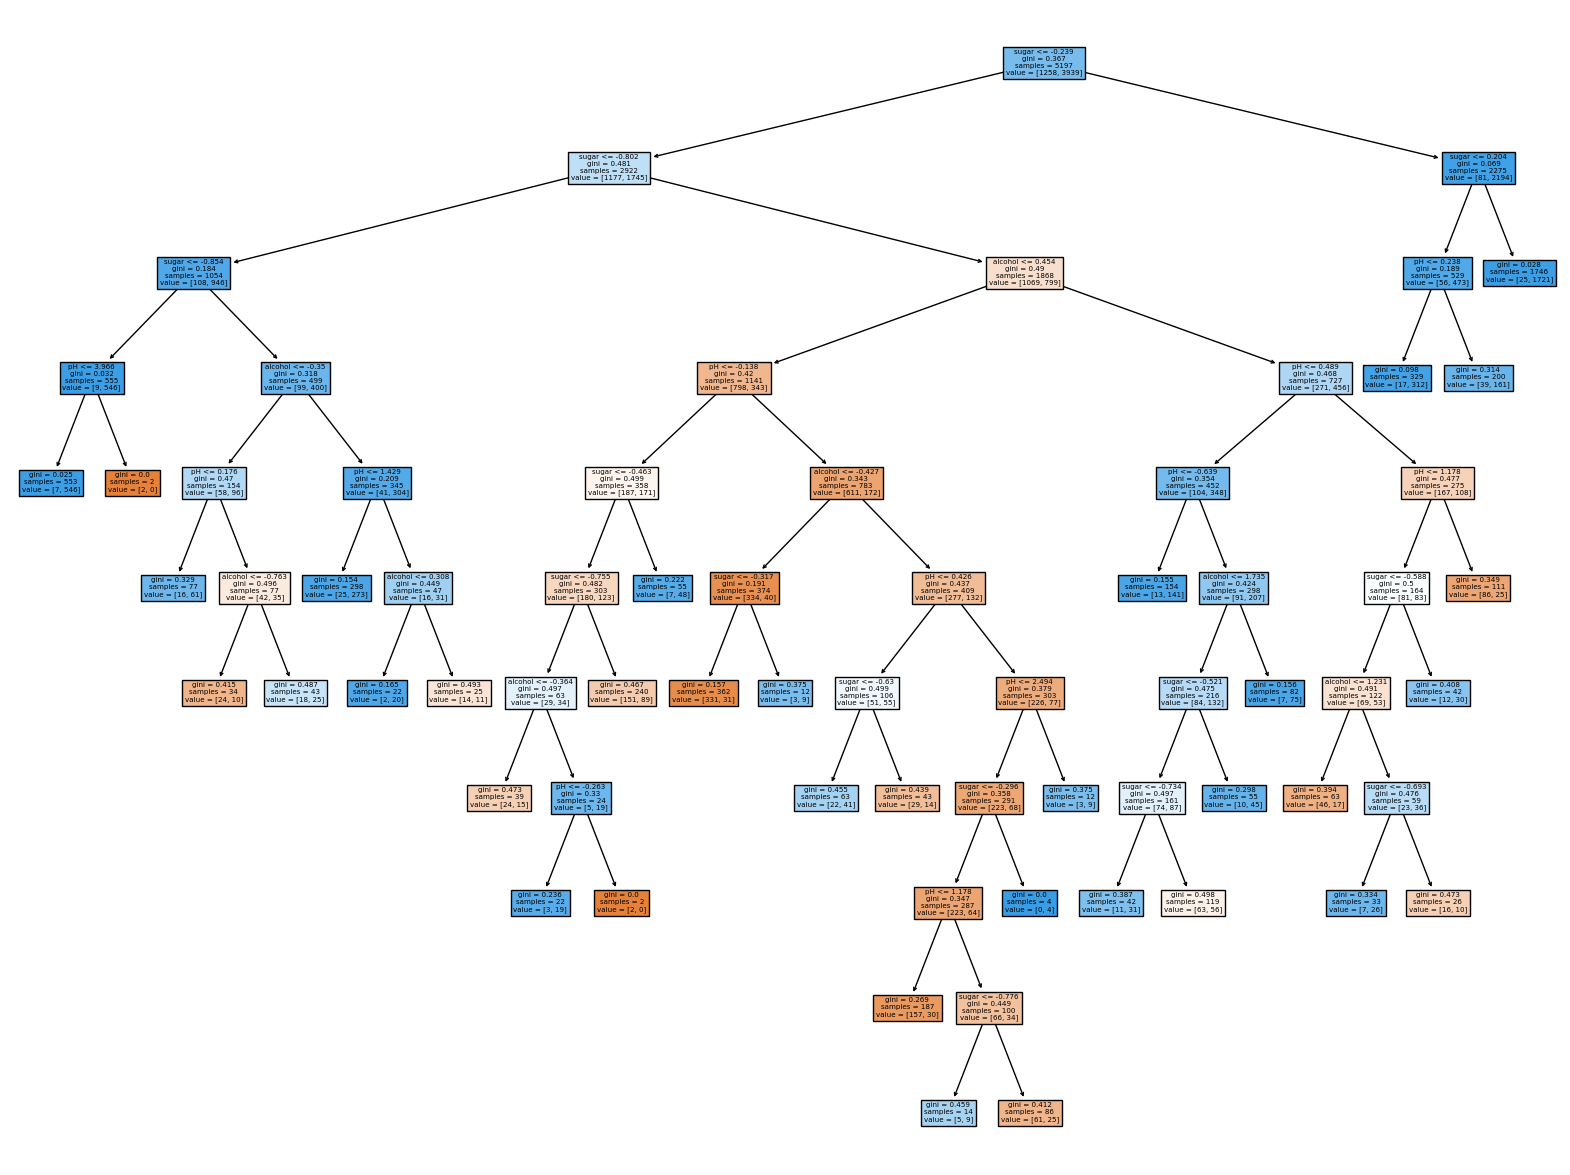

In [ ]:
dt = DecisionTreeClassifier(min_impurity_decrease = 0.0005, random_state = 42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))
plt.figure(figsize = (20, 15))
plot_tree(dt, filled = True, feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

# 교차 검증과 그리드 서치



**검증 세트**

테스트 세트를 사용하지 않고 과대적합/과소적합을 판단하고 하이퍼파라미터 튜닝을 하기 위해 훈련세트세의 약 20%를 떼어낸 것

1. 훈련세트로 모델 훈련
2. 검증세트로 평가하며 하이퍼파라미터 수정
3. 변경된 하이퍼파라미터에서 훈련세트와 검증세트를 합친 전체 훈련 데이터에서 모델 다시 훈련
4. 테스트 세트에서 최종 점수 평가


In [ ]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [ ]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size = 0.2, random_state = 42)

In [ ]:
#검증세트 나누기
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size = 0.2, random_state = 42)

In [ ]:
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [ ]:
#훈련과 평가
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


**교차 검증**

검증 세트를 떼어 내어 평가하는 과정을 반복하여 평균을 최종 점수로 사용

- 검증 데이터를 만들어 훈련 데이터가 줄어듬으로써 모델 성능이 저하되는 것을 방지
- 10-폴드 교차검증처럼 대부분의 데이터를 훈련에 사용하고도 각 폴드에서 계산한 검증 점수를 평균하여 안정된 점수를 얻음
- 각각의 폴드에서 모델을 학습하고 평가한 후에 해당 폴드의 모델과 관련된 변수들을 초기화
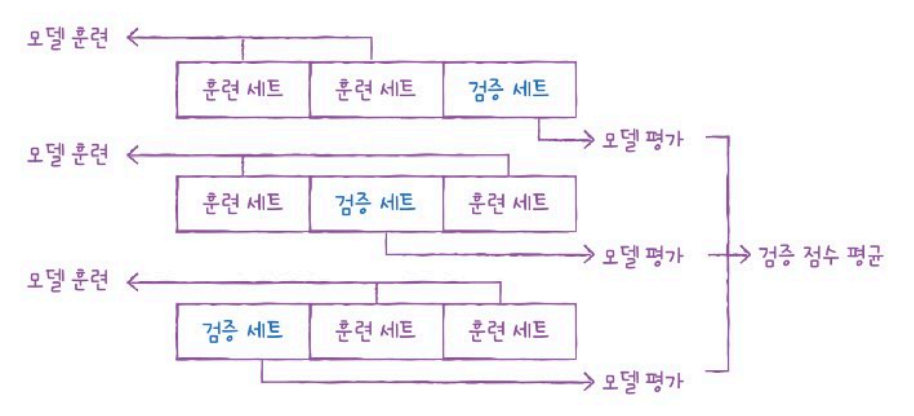

Q. 검증 세트의 평균을 내는 이유
 - 여러 폴드를 사용함으로써 특정 데이터에 의존적이지 않고, 더 일반적인 성능 측정을 얻을 수 있음
 - 모델의 최적의 파라미터를 찾는 것이 목적이기에 훈련/검증 셋의 구성이 바뀌는 것은 문제없음

cross_validate 함수
- default 5-fold
- 훈련 세트 전체 전달
- test score 키의 평균 사용
- 훈련세틀를 섞고 분할하려면 별도의 분할기 지정

In [ ]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)

{'fit_time': array([0.01113439, 0.01801276, 0.01488829, 0.0109272 , 0.01212931]), 'score_time': array([0.00164676, 0.00172162, 0.00163198, 0.00336146, 0.00161934]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [ ]:
import numpy as np
print(np.mean(scores['test_score']))

0.855300214703487


In [ ]:
# 훈련 세트 섞은 후 10-폴드 교차검증
from sklearn.model_selection import StratifiedKFold
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))


0.8574181117533719


**하이퍼파라미터 튜닝**

- 한 매개변수의 최적값은 다른 매개변수의 값에 따라 달라지므로 모든 매개변수를 동시에 바꿔가며 최적값을 찾는 것이 중요

**그리드 서치**

- 하이퍼 파라미터 탐색과 교차검증 한번에 수행
- default cv = 5
- 5 * 5(리스트 값들) -> 25개 모델 훈련
- n_jobs 로 CPU 코어 수 지정 (모두-> -1)
- 최적의 매개변수 조합으로 전체 훈련세트 다시 훈련

In [ ]:
from sklearn.model_selection import GridSearchCV
#다른 매개변수는 기본값 사용, 탐색할 매개변수와 그 값들을 딕셔너리로 저장
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
#그리드 서치 객체 만듬
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)

In [ ]:
gs.fit(train_input, train_target)


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [ ]:
dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [ ]:
print(gs.best_params_)

{'min_impurity_decrease': 0.0001}


In [ ]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [ ]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


더 복잡한 매개변수 조합

- 9개X15개X10개X5(폴드 수 ) -> 6750개 모델

In [ ]:
params = {'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
          'max_depth' : range(5, 20, 1),
          'min_samples_split' : range(2, 100, 10)
          }

In [ ]:
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42), params, n_jobs = -1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [ ]:
print(gs.best_params_)

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8683865773302731


위와 같이 매개변수의 값이 수치일 때 리스트로 값의 목록을 전달하기엔 그 간격을 미리 정하기 어려움

**랜덤서치**

매개변수를 샘플링할 수 있는 확률 분포 객체 전

In [ ]:
from scipy.stats import uniform, randint #각각 주어진 범위에서 실숫값, 정수값을 고르게 샘플링

rgen = randint(0, 10)
np.unique(rgen.rvs(1000), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 94,  87, 106,  98, 107, 109,  92, 115,  94,  98]))

In [ ]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1, 25),
          }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a2020>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a58e30a37f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a1930>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a1d50>},
                   random_state=42)

In [ ]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [ ]:
print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [ ]:
dt = gs.best_estimator_

print(dt.score(test_input, test_target))

0.86


**확인 문제**

In [ ]:
gs = RandomizedSearchCV(DecisionTreeClassifier(splitter='random', random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42,
                                                    splitter='random'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a2020>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a58e30a37f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a1930>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a58e30a1d50>},
                   random_state=42)

In [ ]:
print(gs.best_params_)
print(np.max(gs.cv_results_['mean_test_score']))

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 43, 'min_impurity_decrease': 0.00011407982271508446, 'min_samples_leaf': 19, 'min_samples_split': 18}
0.8458726956392981
0.786923076923077


# 앙상블 학습
정형 데이터(ex.csv)를 다루는 데 가장 뛰어난 성과를 내는 알고리즘들의 집합

# 랜덤 포레스트
앙상블 학습의 대표 알고리즘
- 결정 트리를 랜덤하게 만들어서 숲을 만들고 각 결정 트리의 예측을 사용해 최종 예측을 만듬
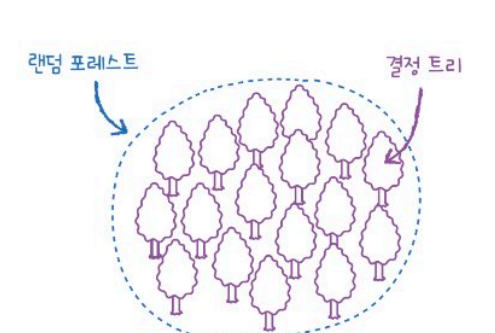

**부트 스트랩 샘플**
데이터 세트에서 중복을 허용하여 데이터를 샘플링 하는 방식
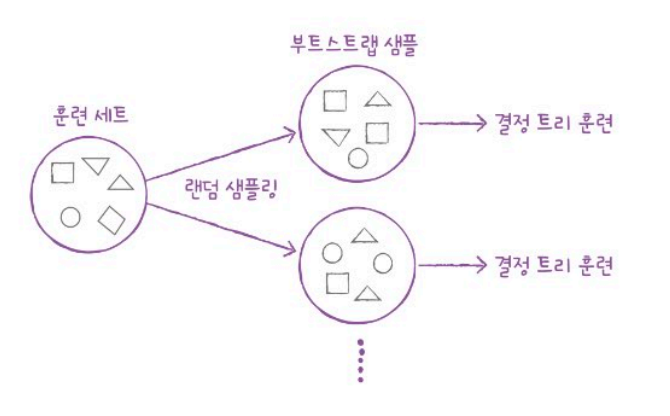

**노드 분할 방법**
1. 일부 특성 무작위로 고르기

분류 -> 특성 개수의 제곱근 만큼 랜덤 선택

회귀 -> 전체 특성 사용

2. 최적의 분할 찾기

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [ ]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


랜덤 포레스트는 특성의 일부를 랜덤하게 선택하기 때문에 일반 '결정 트리'의 특성 중요도와 비교했을 때 중요도가 좀 더 고르게 분포하는 것을 확인할 수 있음(일반화 성능 상승)

부트스트랩 샘플에 포함되지 않은 훈련 셋(OOB)으로 결정 트리 평가

In [ ]:
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


# 엑스트라 트리
랜덤 포레스트와 매우 유사하지만 부트스랩 샘플을 사용하지 않는 앙상블 학습 알고리즘

- 전체 훈련 세트로 결정 트리 만듬
- 최적의 분할을 찾기 않고 무작위로 분할
- 보통 특성을 무작위로 분할한다면 성능이 낮아지지만 많은 트리를 앙상블 학습 하여 과대적합을 막음

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9974503966084433 0.8887848893166506


In [ ]:
et.fit(train_input, train_target)
print(et.feature_importances_)

[0.20183568 0.52242907 0.27573525]


# 그래디언트 부스팅
깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차 보완하는 앙상블 학습 알고리즘

- 깊이가 낮아 과대적합에 강함
- 경사하강법 사용하며 트리 추가

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8881086892152563 0.8720430147331015


In [ ]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, train_input, train_target, return_train_score=True, n_jobs=-1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9464595437171814 0.8780082549788999


# 히스토그램 기반 그래디언트 부스팅
